In [2]:
run "C:\Users\Charles Klewicki\Google Drive\school\Graduate\FPF Summer 2017\PIV Python Scripts\FPF_PIV_CODE\Drummonds_Scripts\PIV.py"

In [3]:
run "C:\Users\Charles Klewicki\Google Drive\school\Graduate\FPF Summer 2017\PIV Python Scripts\FPF_PIV_CODE\Drummonds_Scripts\hotwire.py"

In [6]:
import pandas as pd
import numpy as np
import time
import sys
import h5py
from scipy.signal import medfilt
import matplotlib.pyplot as plt

################################################################
#   PURPOSE
#   1. Readin in PIV data_sets
#   2. Find Mask
#   3. Resize
#   4. Determine mean profiles and HO quantities
################################################################

def filt_images(tempU): 
    Umean = np.mean(np.mean(tempU))
    STDmean = np.mean(np.var(tempU, axis=0))**(1/2)
    len1 = len(tempU)
    for j in range(0, len1):
        temp_mean = np.mean(np.mean(tempU[j]))
        if temp_mean > Umean + 2*STDmean:
            tempU[j] = tempU[j]*np.nan
        if temp_mean < Umean - 2*STDmean:
            tempU[j] = tempU[j]*np.nan
    return(tempU)


## to work on ##
################
# -work to read in top line of PIV file such that size and units and be predetermined
# determine better way to store PIV datasets

## INITIAL CODE USED FOR READING IN

#Parameter set
date = '072017'
filter_width = 21
num_images = 10911
sizex = 129
sizey = 129
walloffset = 8.29
side_error = 2

#list name of data set folders
base_name = dict()
#List the base name for each test to be read in and analyzed, names taken directly from folder
base_name[0] = 'D:/test_072017/Cam_Date=170720_Time=103432_TR_SeqPIV_MP(2x16x16_50ov_ImgCorr)=unknown'


#Initalize variables
num_tests = len(base_name)
U = np.ndarray([num_tests, num_images-1, sizey, sizex])
V = np.ndarray([num_tests, num_images-1, sizey, sizex])
u_filt = np.ndarray([num_tests, num_images-1, sizey, sizex])
v_filt = np.ndarray([num_tests, num_images-1, sizey, sizex])
umean = np.ndarray([num_tests, sizey, sizex])
vmean = np.ndarray([num_tests, sizey, sizex])
mask = np.zeros([num_tests, 3]) #is the second value 3 because we have a bottom and two side masks?
umean_profile = dict()
vmean_profile = dict()
urms_profile = dict()
vrms_profile = dict()
uvprime_profile = dict()
for j in base_name:
    #Read in
    [x, y, U[j], V[j]] = piv_readin_mod(base_name[j], num_images, sizey, sizex)
    #filter out images that contain spurious vectors
    U[j] = filt_images(U[j])
    V[j] = filt_images(V[j])
    #Filter data sets (median filter along axis=0 (through images))
    #u_filt[j] = medfilt(U[j, :], kernel_size=[filter_width, 1, 1])
    #v_filt[j] = medfilt(V[j, :], kernel_size=[filter_width, 1, 1])
    u_filt[j] = U[j, :]
    v_filt[j] = V[j, :]
    #Obtain mean vecotr field
    umean[j] = np.nanmean(u_filt[j], axis=0)
    vmean[j] = np.nanmean(v_filt[j], axis=0)
    #print('Done Reading')
    #bar.finish()
    #determine mask position
tempmask = mask_loc(umean[j])
mask = list(tempmask)
## Resize vecotr field to crop out masked areas and
# create new vectors which take out the masked areas and any side errors
sizex_mask = mask[3] - mask[2] - side_error*2
sizey_mask = mask[1] - mask[0]
Umask = np.ndarray([num_tests, num_images-1, sizey_mask, sizex_mask])
Vmask = np.ndarray([num_tests, num_images-1, sizey_mask, sizex_mask])
umean = np.ndarray([num_tests, sizey_mask, sizex_mask])
vmean = np.ndarray([num_tests, sizey_mask, sizex_mask])
for j in base_name:
    Umask[j] = -1*U[j][:, mask[0]:mask[1], int(mask[2]+side_error):int(mask[3]-side_error)]
    Vmask[j] = V[j][:, mask[0]:mask[1], int(mask[2]+side_error):int(mask[3]-side_error)]
    umean[j] = np.nanmean(Umask[j], axis=0)
    vmean[j] = np.nanmean(Vmask[j], axis=0)

## Determine RMS quantities ##
uprime = np.ndarray([num_tests, num_images-1, sizey_mask, sizex_mask])
vprime = np.ndarray([num_tests, num_images-1, sizey_mask, sizex_mask])
uvprime  = np.ndarray([num_tests, num_images-1, sizey_mask, sizex_mask])
uvprime_mean = np.ndarray([num_tests, sizey_mask, sizex_mask])
urms = np.ndarray([num_tests, sizey_mask, sizex_mask])
vrms = np.ndarray([num_tests, sizey_mask, sizex_mask])
for j in range(0, num_tests):
    for jj in range(0, 499):
        uprime[j, jj] = ((Umask[j][jj]-umean[j]))
        vprime[j, jj] = ((Vmask[j][jj]-vmean[j]))
        uvprime[j, jj] = uprime[j, jj]*vprime[j, jj]
    uvprime_mean[j] = np.nanmean(uvprime[j], axis=0)
    urms[j] = np.nanmean(uprime[j]**2, axis=0)**(1/2)
    vrms[j] = np.nanmean(vprime[j]**2, axis=0)**(1/2)

## wall position adjustment ###########
#convert to m and take off wall position as seen in images
x = (x+65.3479)/1000
y = (y-walloffset+9.20251)/1000
xmask = x[ mask[2]:mask[3] ]
ymask = y[ mask[0]:mask[1] ]
## Create Mean Profiles #######
for j in range(0, num_tests):
    umean_profile[j] = np.mean(umean[j], axis=1)
    vmean_profile[j] = np.mean(vmean[j], axis=1)
    urms_profile[j] = np.mean(urms[j], axis=1)
    vrms_profile[j] = np.mean(vrms[j], axis=1)
    uvprime_profile[j] = np.mean(uvprime_mean[j], axis=1)

## Average multiple profiles together
#use this if multiple tests are performed at the same condition
umean_profile_avg = np.zeros(len(umean_profile[0]))
vmean_profile_avg = np.zeros(len(umean_profile[0]))
urms_profile_avg = np.zeros(len(umean_profile[0]))
vrms_profile_avg = np.zeros(len(umean_profile[0]))
uvprime_profile_avg = np.zeros(len(umean_profile[0]))
#average datasets together
for j in range(0, num_tests):
    umean_profile_avg = umean_profile_avg + umean_profile[j]
    vmean_profile_avg = vmean_profile_avg + vmean_profile[j]
    urms_profile_avg = urms_profile_avg + urms_profile[j]
    vrms_profile_avg = vrms_profile_avg + vrms_profile[j]
    uvprime_profile_avg = uvprime_profile_avg + uvprime_profile[j]
#divide profiles by number of tests which were combined
umean_profile_avg = umean_profile_avg / num_tests
vmean_profile_avg = vmean_profile_avg / num_tests
urms_profile_avg = urms_profile_avg / num_tests
vrms_profile_avg = vrms_profile_avg / num_tests
uvprime_profile_avg = uvprime_profile_avg / num_tests

##calculate conf interval
conf = dict()
Neff = 10
conf['u'] =  (np.nanmean(np.nanmean(np.nanvar(Umask, axis=1), axis=0), axis=1))**(1/2) * (1/Neff)**(1/2)
conf['v'] =  (np.nanmean(np.nanmean(np.nanvar(Vmask, axis=1), axis=0), axis=1))**(1/2) * (1/Neff)**(1/2)
conf['urms'] =  (np.nanmean(np.nanvar(urms, axis=0), axis=1))**(1/2) * (1/(2*Neff-1))**(1/2)
conf['vrms'] =  (np.nanmean(np.nanvar(vrms, axis=0), axis=1))**(1/2) * (1/(2*Neff-1))**(1/2)
sigma_u = (np.nanmean(np.nanvar(Umask, axis=1), axis=0))**(1/2)
sigma_v = (np.nanmean(np.nanvar(Vmask, axis=1), axis=0))**(1/2)
conf['uvprime'] = np.nanmean(sigma_u * sigma_v * (1+ (np.nanmean(uvprime_mean, axis=0)/(sigma_u * sigma_v))**2 / (Neff - 1))**(1/2), axis=1)




MemoryError: 

In [5]:
##  WRITE OUT DATA
###################
#open hdf5 file
hdf = pd.HDFStore('D:/test_072017/PIV_' + date + '.h5')
hdf.put('umean_profile_avg', pd.DataFrame(umean_profile_avg))
hdf.put('vmean_profile_avg', pd.DataFrame(vmean_profile_avg))
hdf.put('urms_profile_avg', pd.DataFrame(urms_profile_avg))
hdf.put('vrms_profile_avg', pd.DataFrame(vrms_profile_avg))
hdf.put('uvprime_profile_avg', pd.DataFrame(uvprime_profile_avg))
hdf.put('confidence', pd.DataFrame(conf))
hdf.put('xaxis', pd.Series(xmask))
hdf.put('yaxis', pd.Series(ymask))
hdf.put('mask', pd.DataFrame(mask))
hdf.close()

print('Data Saved!')

Data Saved!


In [4]:
run "C:\Users\Charles Klewicki\Google Drive\school\Graduate\FPF Summer 2017\PIV Python Scripts\FPF_PIV_CODE\Drummonds_Scripts\PIV_inner.py"

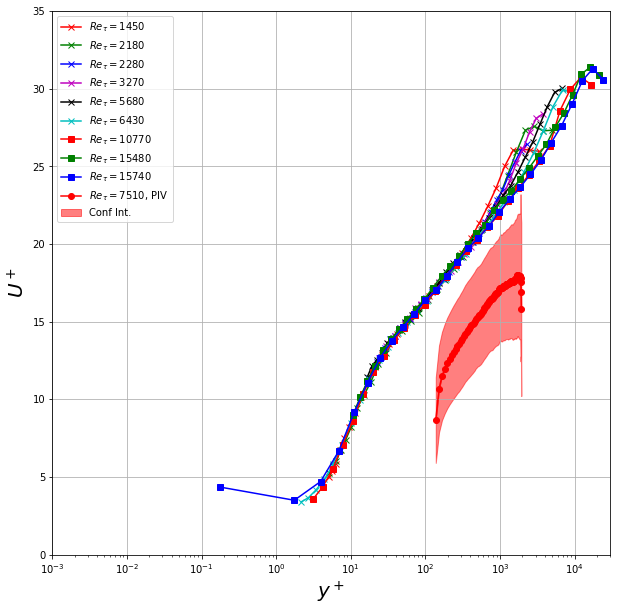

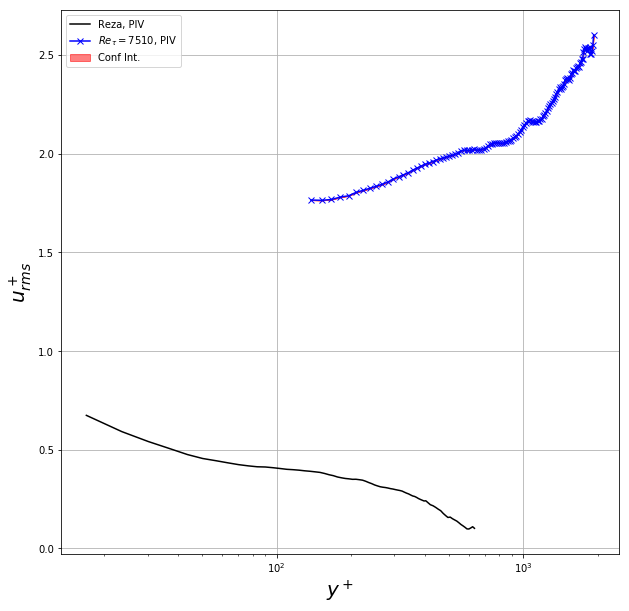

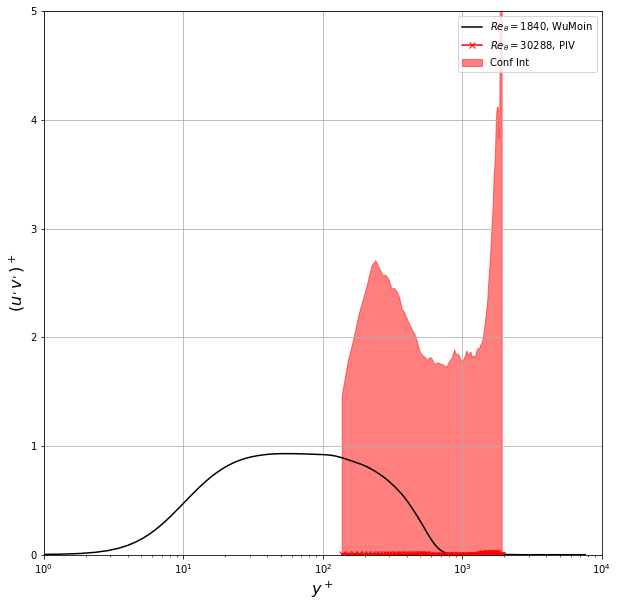

In [11]:
date = '072017'
num_tests = 10
sizex = 129  #Num vertical points
sizey = 129  #num horizontal points
name = 'D:/test_072017/PIV_' + date + '.h5'
utau = [.135]
inner(date,num_tests,sizex,sizey,name,utau)

In [8]:
run "C:\Users\Charles Klewicki\Google Drive\school\Graduate\FPF Summer 2017\PIV Python Scripts\FPF_PIV_CODE\Drummonds_Scripts\PIV_outer.py"

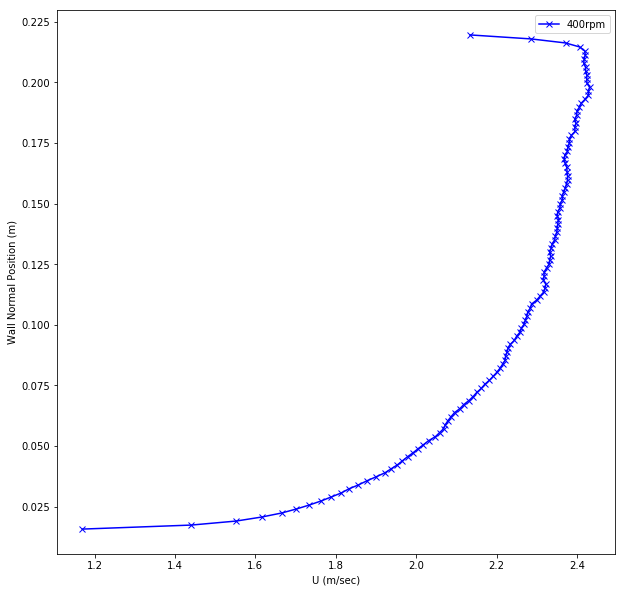

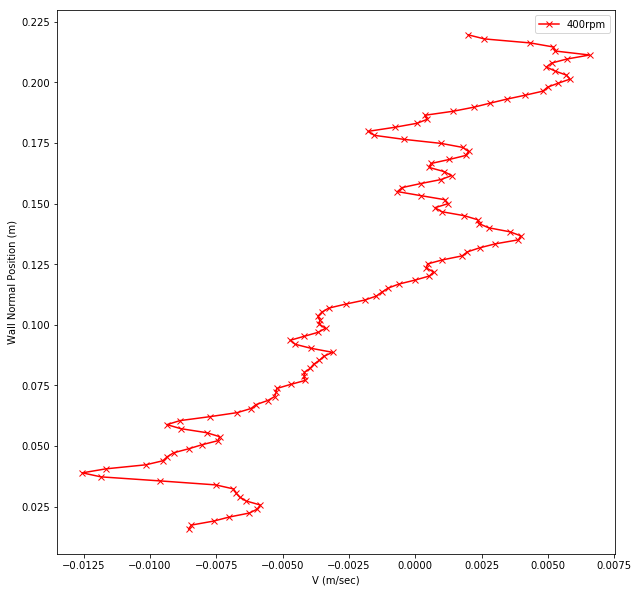

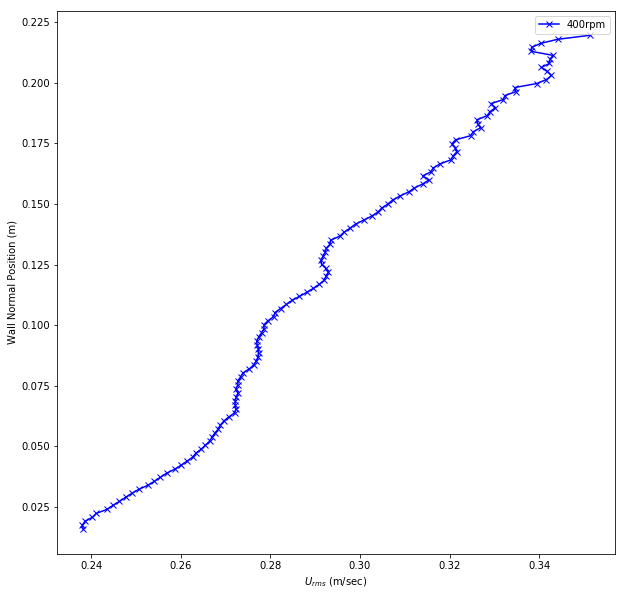

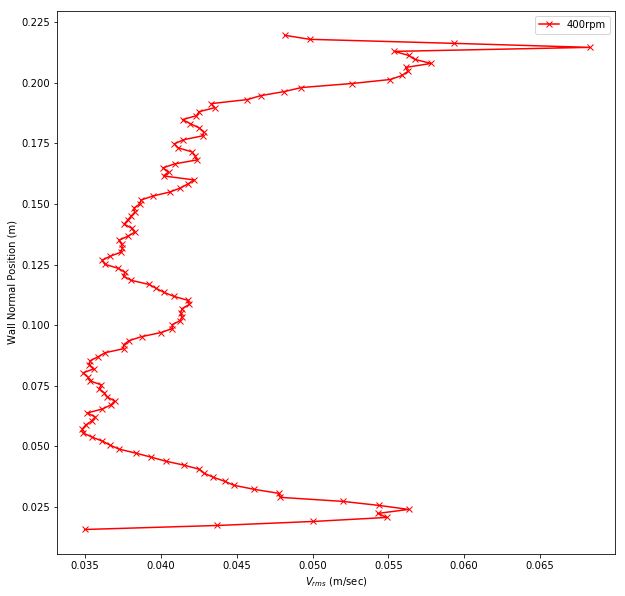

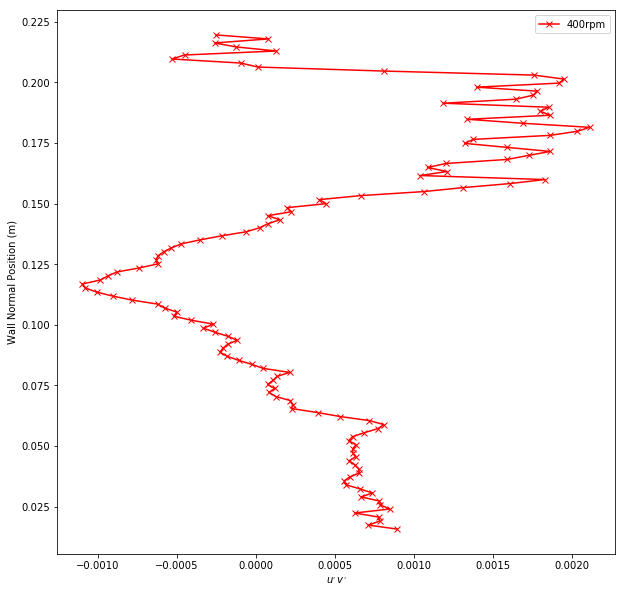

Done!


In [9]:
# from matplotlib.backends.backend_gtkagg import FigureCanvasGTKAgg as FigureCanvas
# from matplotlib.backends.backend_gtkagg import NavigationToolbar2GTKAgg as NavigationToolbar
outer(date,num_tests,sizex,sizey,name)